In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import json, os, pickle, glob#, natsort
import corner
import astropy.units as u

In [3]:
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.utils import bayes_fac
#from targeted_cws_ng15 import post_processing as pp

In [4]:
# replace with names of your paths
chains_path = '/gpfs/gibbs/project/mingarelli/bbl29/targeted_cws_ng15/data/chains/ng15_v1p1'
priors_path = '/gpfs/gibbs/project/mingarelli/bbl29/targeted_cws_ng15/data/priors'

In [5]:
# names of targets (for getting corepaths)
targets = ['3C66B', 'HS_0926+3608', 'HS_1630+2355', 'OJ287', 'PKS_2131-021',
           'PKS_J0805-0111', 'SDSS_J092911.35+2037', 'SDSS_J114857.33+1600', 'SDSS_J131706.19+2714',
           'SDSS_J133516.17+1833', 'SDSS_J134855.27-0321', 'SDSS_J140704.43+2735', 'SDSS_J160730.33+1449',
           'SDSS_J164452.71+4307', 'SNU_J13120+0641']

In [6]:
# names for the plot
targets_fancy = ['3C66B', 'HS 0926+3608', 'HS 1630+2355', 'OJ287', 'PKS 2131$-$021',
                 'PKS J0805$-$0111', 'SDSS J092911.35+2037', 'SDSS J114857.33+1600', 'SDSS J131706.19+2714',
                 'SDSS J133516.17+1833', 'SDSS J134855.27$-$0321', 'SDSS J140704.43+2735', 'SDSS J160730.33+1449',
                 'SDSS J164452.71+4307', 'SNU J13120+0641']

Load cores

In [7]:
cores = {}
for t, tf in zip(targets, targets_fancy):
    print(tf)
    cores[tf] = co.Core(corepath=f'{chains_path}/{t}_UL/core.h5', label=tf, burn=0)

3C66B
HS 0926+3608 from HDF5 file....
HS 1630+2355 from HDF5 file....
OJ287ng data from HDF5 file....
PKS 2131$-$021rom HDF5 file....
PKS J0805$-$0111m HDF5 file....
SDSS J092911.35+2037F5 file....
SDSS J114857.33+1600F5 file....
SDSS J131706.19+2714F5 file....
SDSS J133516.17+1833F5 file....
SDSS J134855.27$-$0321 file....
SDSS J140704.43+2735F5 file....
SDSS J160730.33+1449F5 file....
SDSS J164452.71+4307F5 file....
SNU J13120+0641om HDF5 file....


Get upper limits

In [8]:
log10_mc_UL = {}
for t in targets_fancy:
    if 'log10_mc' in cores[t].params:
        log10_mc_UL[t] = cores[t].get_param_credint('log10_mc', onesided=True, interval=95)
    elif 'mc' in cores[t].params:
        log10_mc_UL[t] = np.log10(cores[t].get_param_credint('mc', onesided=True, interval=95))
# Sort in order of smallest to highest chirp mass UL for plotting
idxs = np.argsort(np.array(list(log10_mc_UL.values())))
targets_sorted = list(np.array(targets)[idxs])
log10_mc_UL = dict(sorted(log10_mc_UL.items(), key=lambda item: item[1]))

## 15 panel figure

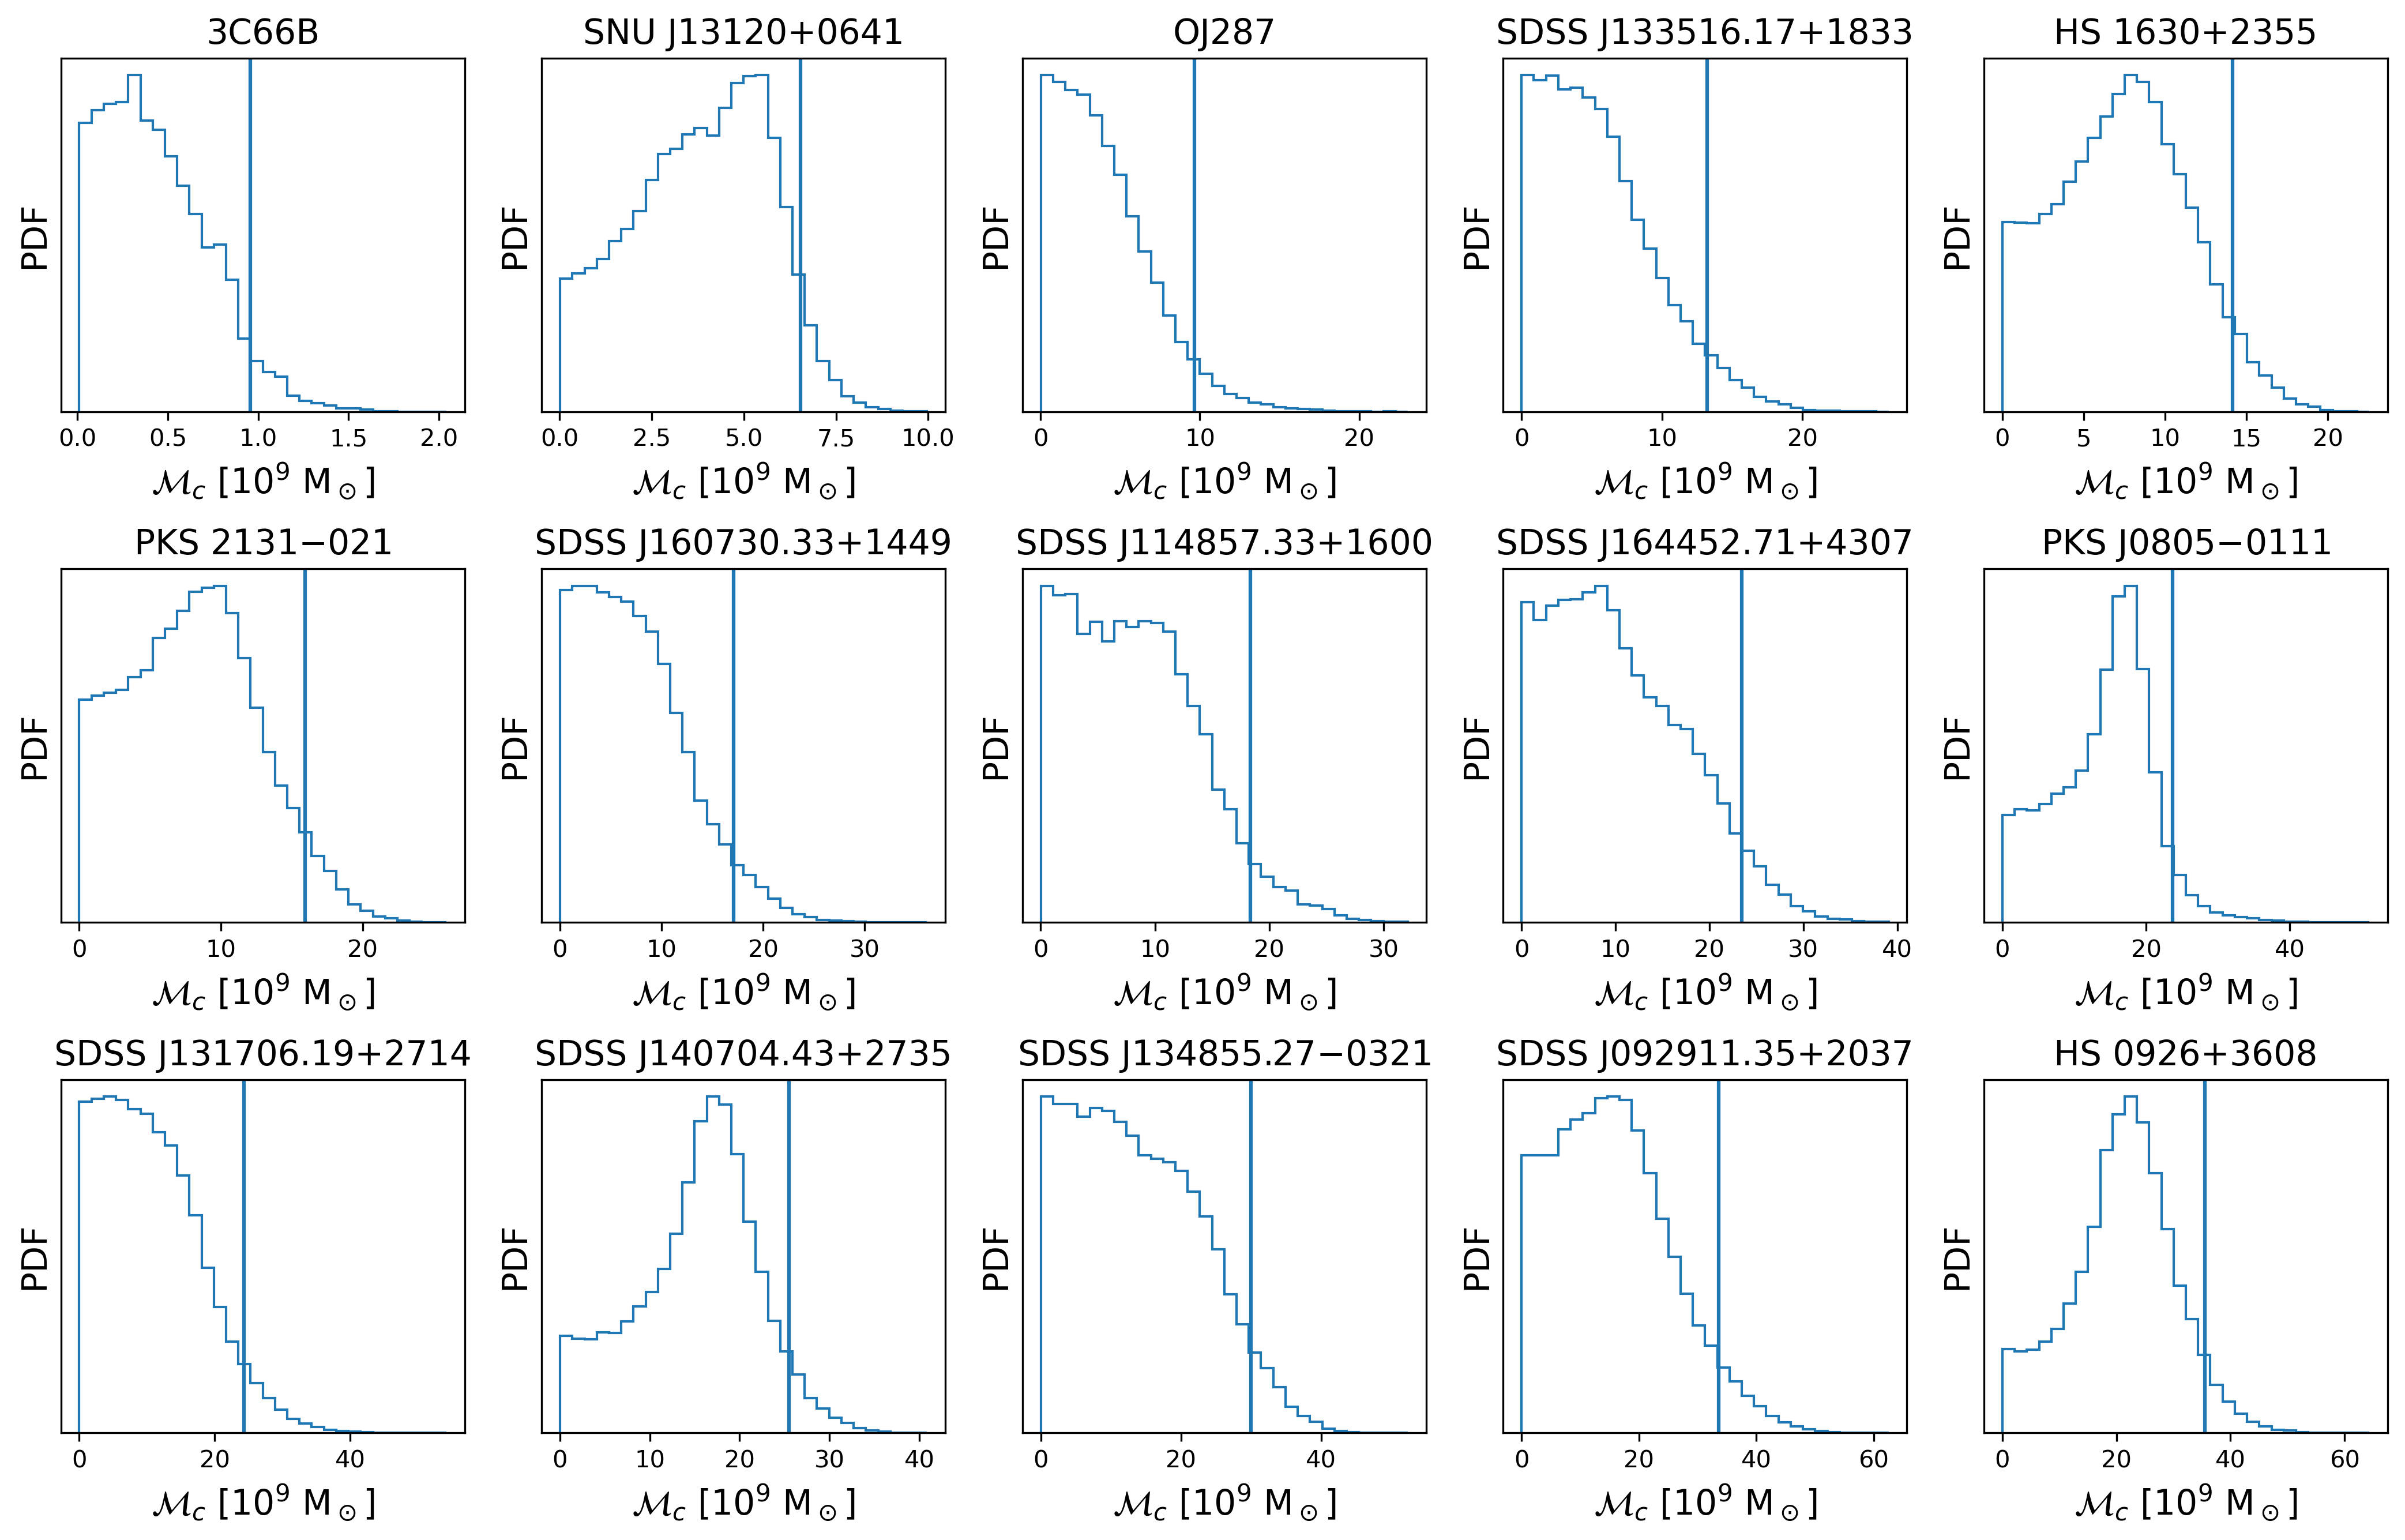

In [52]:
fig, axes = plt.subplots(3,5,figsize=(14,9))
for tf, ax in zip(log10_mc_UL, axes.flatten()):
    ax.set_title(tf, fontsize='x-large')
    ax.set_xlabel(r"$\mathcal{M}_c$ [$10^9$ M$_\odot$]", fontsize='x-large')
    ax.set_ylabel(r"PDF", fontsize='x-large')
    ax.set_yticks([])
    ax.hist(cores[tf]("mc")/1e9, histtype='step', bins=30, density=True)
    ax.axvline(cores[tf].get_param_credint('mc', onesided=True, interval=95)/1e9,
               color='C0', label=r'$\log_{10}\mathcal{M}_c^{95\%}$ (15yr)')
fig.tight_layout()
plt.show()

Here is a version with EM estimates overplotted. These are loaded in from a dictionary for each target, but you can change the code to load these values in however you want.

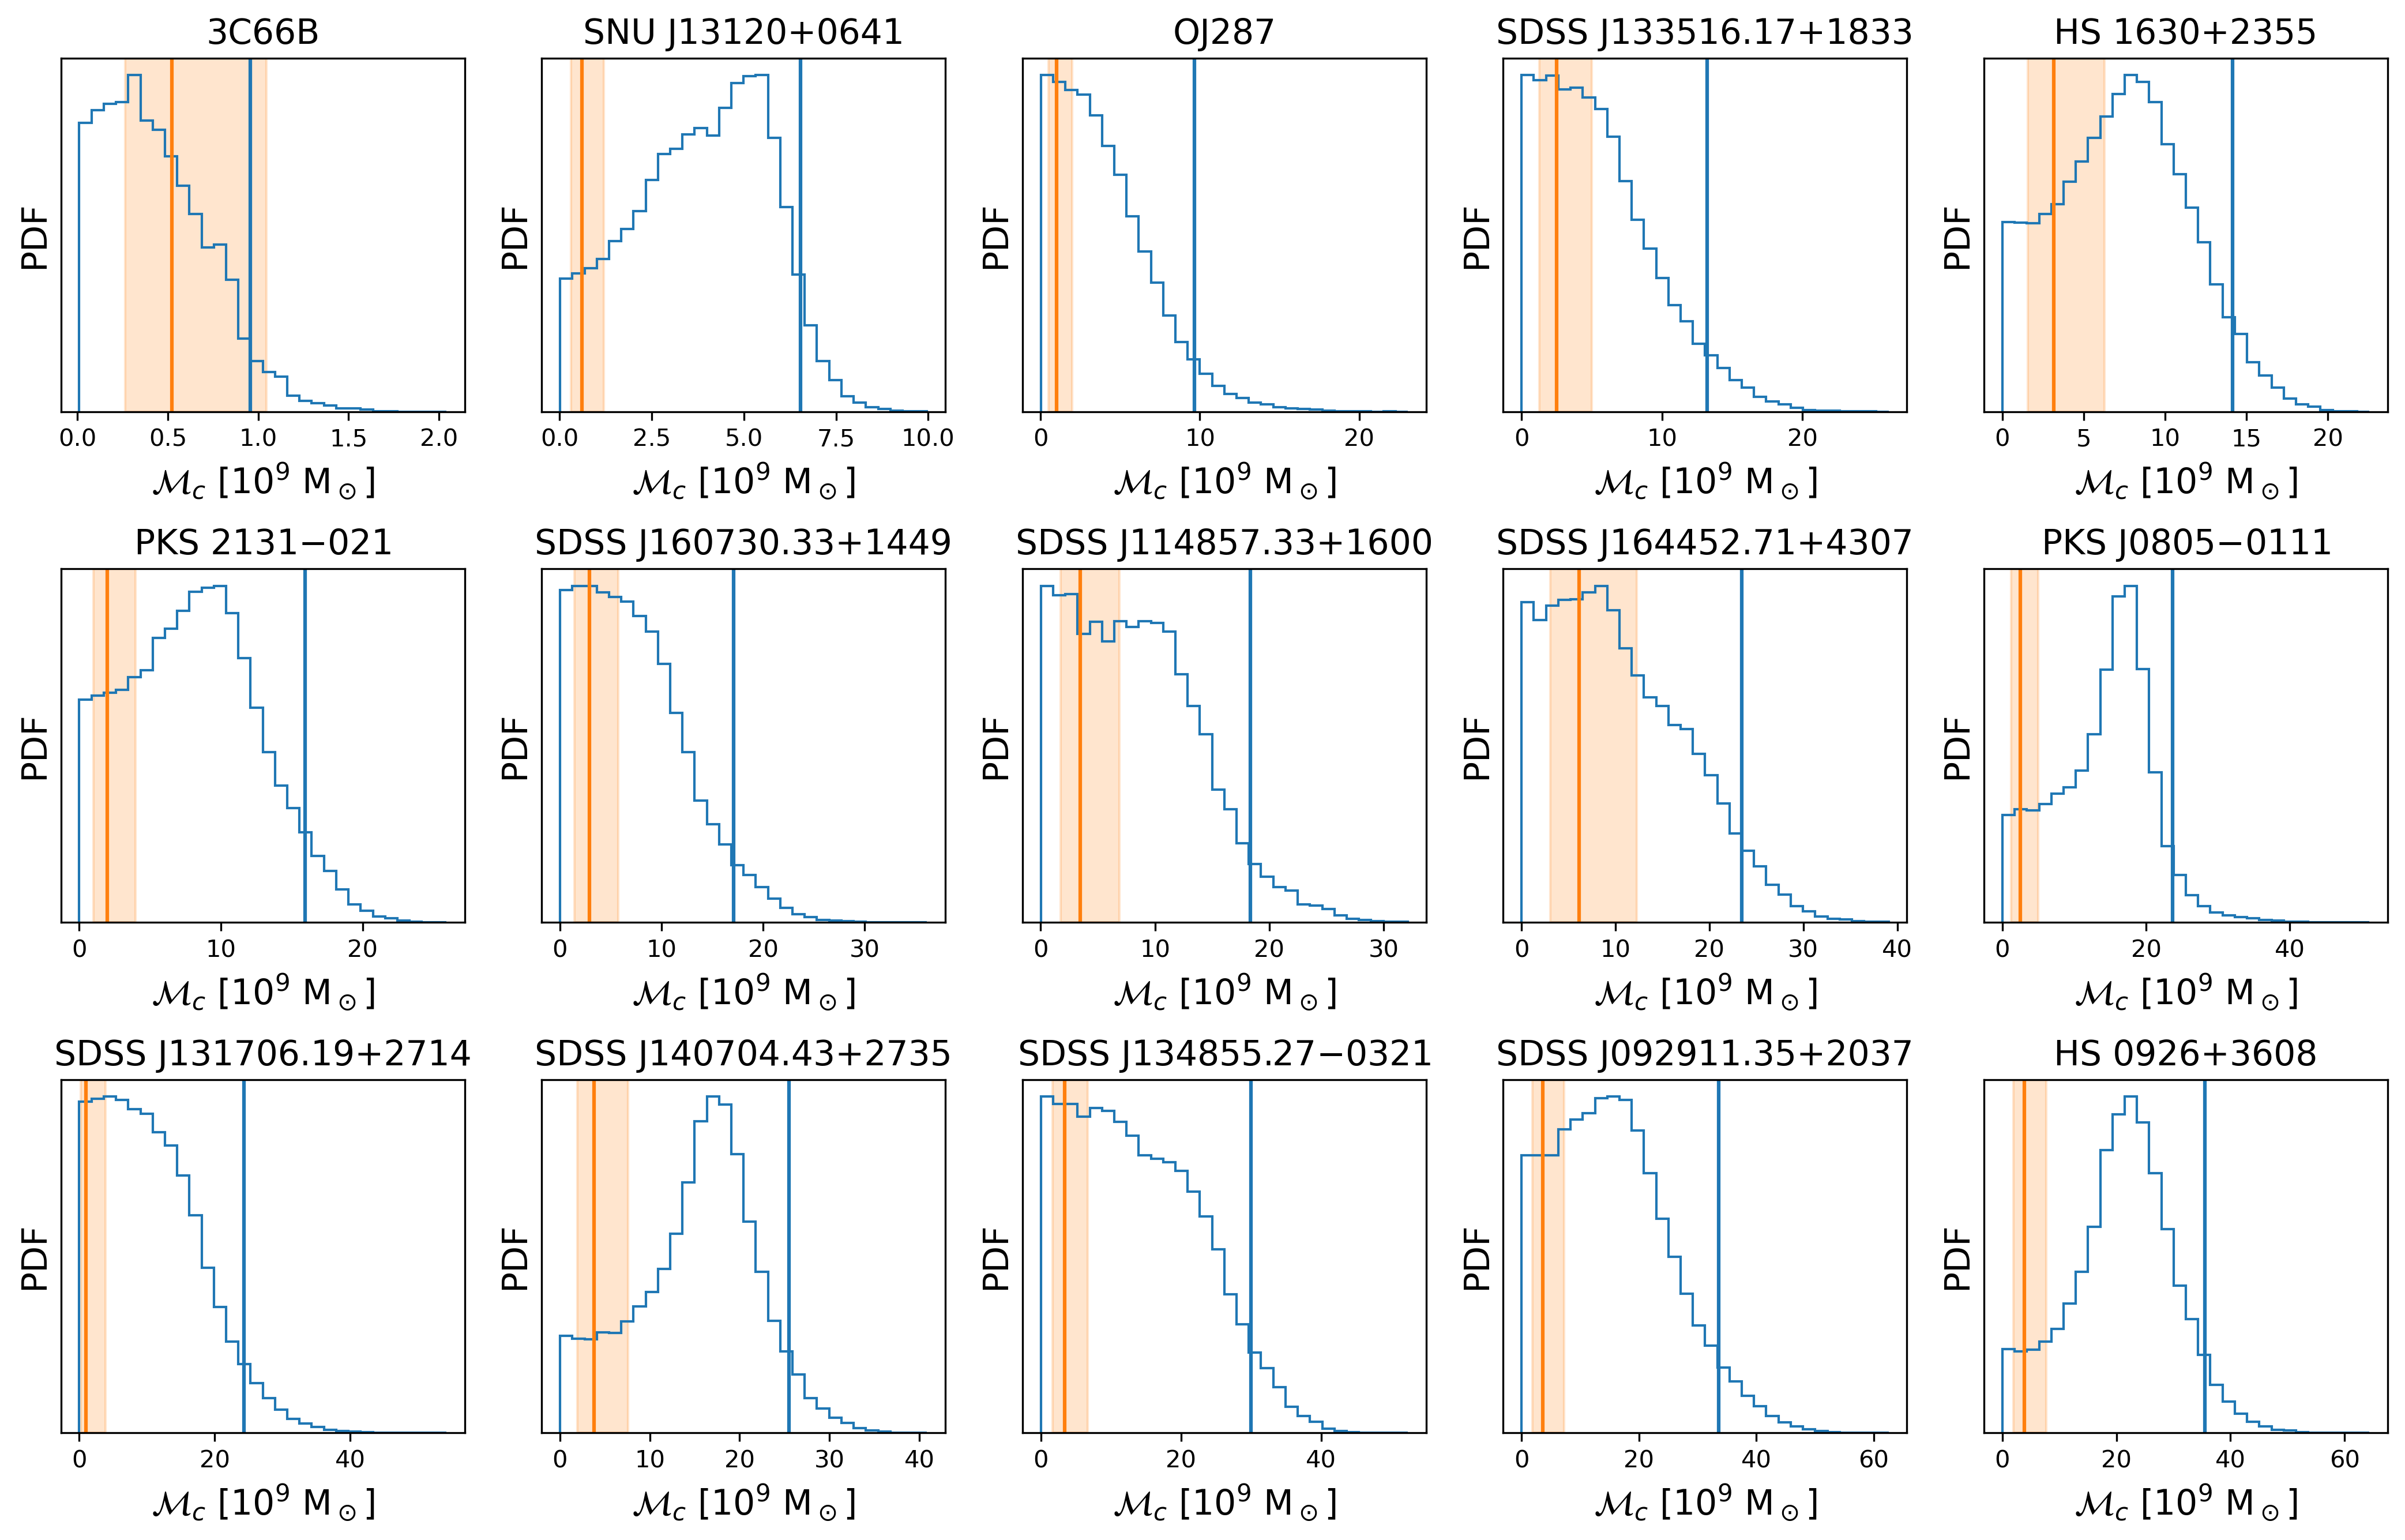

In [51]:
def get_mc_prior_mean_std(core, path, target):
    idx = core.params.index('log10_mc')
    pline = core.priors[idx]
    prior_path = f'{path}/{target}_priors.json'
    with open(prior_path, 'r') as f:
        astro_priors = json.load(f)
    return astro_priors['log10_Mc'], astro_priors['log10_Mc_sigma']

fig, axes = plt.subplots(3,5,figsize=(14,9))
for t, tf, ax in zip(targets_sorted, log10_mc_UL, axes.flatten()):
    ax.set_title(tf, fontsize='x-large')
    ax.set_xlabel(r"$\mathcal{M}_c$ [$10^9$ M$_\odot$]", fontsize='x-large')
    ax.set_ylabel(r"PDF", fontsize='x-large')
    ax.set_yticks([])
    # Here get the EM estimates
    EM_mean, EM_std = get_mc_prior_mean_std(cores[tf], priors_path, t)
    ax.hist(cores[tf]("mc")/1e9, histtype='step', bins=30, density=True)
    ax.axvline(cores[tf].get_param_credint('mc', onesided=True, interval=95)/1e9,
               color='C0', label=r'$\log_{10}\mathcal{M}_c^{95\%}$ (15yr)')
    ylim = ax.get_ylim()
    ax.axvline(10**EM_mean/1e9, label='EM estimate', color='C1')
    ax.fill_between([10**(EM_mean-EM_std)/1e9,10**(EM_mean+EM_std)/1e9],
                    [ylim[0],ylim[0]], [ylim[1],ylim[1]],
                    alpha=0.2, color='C1')
    ylim = ax.set_ylim(ylim)
fig.tight_layout()
plt.show()

Just 3C66B

In [8]:
def get_mc_prior_mean_std(core, path, target):
    idx = core.params.index('log10_mc')
    pline = core.priors[idx]
    prior_path = f'{path}/{target}_priors.json'
    with open(prior_path, 'r') as f:
        astro_priors = json.load(f)
    return astro_priors['log10_Mc'], astro_priors['log10_Mc_sigma']

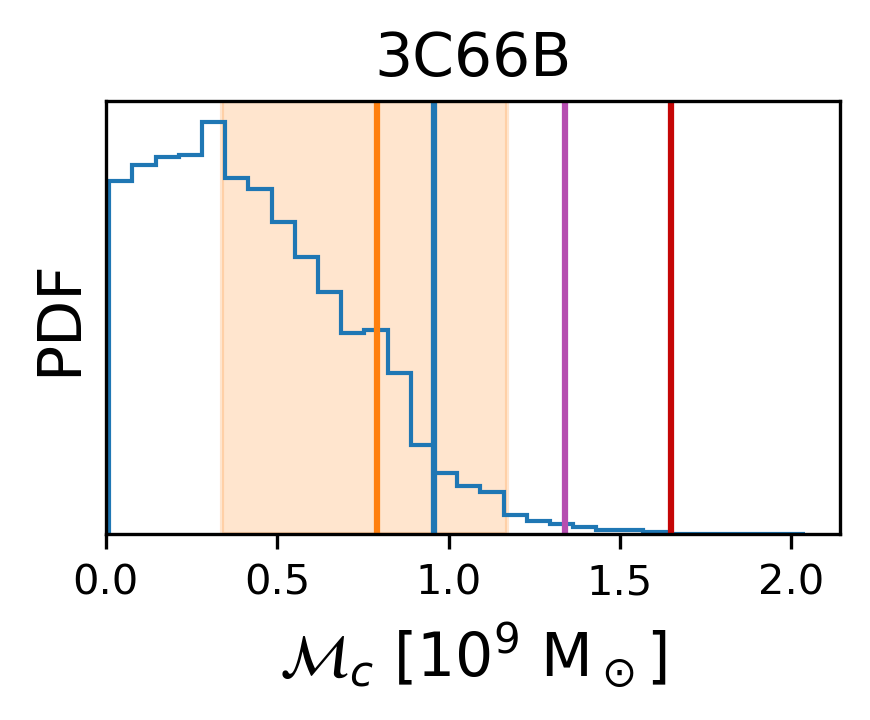

In [27]:
fig, ax = plt.subplots(figsize=(3,2.5))
t = '3C66B'
tf = '3C66B'
ax.set_title(tf, fontsize='x-large')
ax.set_xlabel(r"$\mathcal{M}_c$ [$10^9$ M$_\odot$]", fontsize='x-large')
ax.set_ylabel(r"PDF", fontsize='x-large')
ax.set_yticks([])
# Here get the EM estimates
#EM_mean, EM_std = get_mc_prior_mean_std(cores[tf], priors_path, t)
EM_mean = 7.9e8
EM_low = -4.5e8
EM_high = 3.8e8
ax.hist(cores[tf]("mc")/1e9, histtype='step', bins=30, density=True)
ax.axvline(cores[tf].get_param_credint('mc', onesided=True, interval=95)/1e9,
           color='C0', label=r'$\log_{10}\mathcal{M}_c^{95\%}$ (15yr)')
ylim = ax.get_ylim()
ax.axvline(EM_mean/1e9, label='EM estimate', color='C1')
ax.fill_between([(EM_mean+EM_low)/1e9,(EM_mean+EM_high)/1e9],
                [ylim[0],ylim[0]], [ylim[1],ylim[1]],
                alpha=0.2, color='C1')
UL_12p5yr = 1.34e9
UL_11yr = 1.65e9
ax.axvline(UL_12p5yr/1e9, label='EM estimate', color='#b64db0')
ax.axvline(UL_11yr/1e9, label='EM estimate', color='#c50606')
ax.set_xlim([0, ax.get_xlim()[1]])
ylim = ax.set_ylim(ylim)
fig.tight_layout()
plt.show()

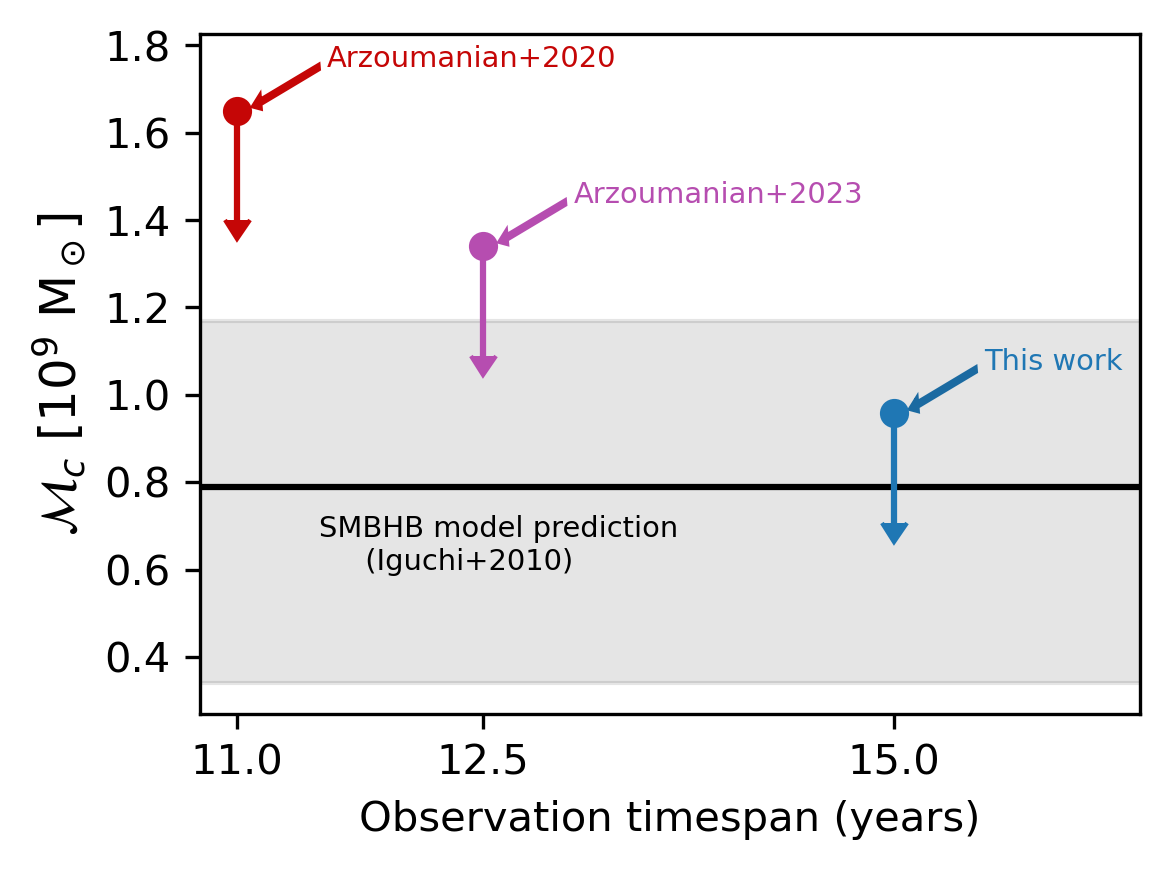

In [9]:
fig, ax = plt.subplots(figsize=(4,3))
t = '3C66B'
tf = '3C66B'
#ax.set_title('3C66B Upper Limits', fontsize='x-large')
ax.set_ylabel(r"$\mathcal{M}_c$ [$10^9$ M$_\odot$]", fontsize='large')
#ax.set_ylabel(r"PDF", fontsize='x-large')
ax.set_xticks([11,12.5,15])
#ax.set_xticklabels(['NG11\n(Arzoumanian+2020)','NG12.5\n(Arzoumanian+2023)','NG15\n(This work)'],
#                   fontsize='medium', rotation=30)
ax.set_xlabel("Observation timespan (years)", fontsize='medium')
# Plot limits
UL_15yr = cores[tf].get_param_credint('mc', onesided=True, interval=95)
UL_12p5yr = 1.34e9
UL_11yr = 1.65e9
ax.errorbar(x=[15],y=[UL_15yr/1e9],yerr=[0.25], color='C0', marker='o', uplims=True)
ax.errorbar(x=[12.5],y=[UL_12p5yr/1e9],yerr=[0.25], color='#b64db0', marker='o', uplims=True)
ax.errorbar(x=[11],y=[UL_11yr/1e9],yerr=[0.25], color='#c50606', marker='o', uplims=True)
ax.arrow(11.5,UL_11yr/1e9+0.1, -0.4,-0.09, width=0.01, length_includes_head=True, color='#c50606')
ax.arrow(13,UL_12p5yr/1e9+0.1, -0.4,-0.09, width=0.01, length_includes_head=True, color='#b64db0')
ax.arrow(15.5,UL_15yr/1e9+0.1, -0.4,-0.09, width=0.01, length_includes_head=True, color='C0')
ax.text(11.55,UL_11yr/1e9+0.1, 'Arzoumanian+2020', color='#c50606', fontsize='x-small')
ax.text(13.05,UL_12p5yr/1e9+0.1, 'Arzoumanian+2023', color='#b64db0', fontsize='x-small')
ax.text(15.55,UL_15yr/1e9+0.1, 'This work', color='C0', fontsize='x-small')
#ax.arrow(13,UL_12p5yr/1e9+0.1, -0.4,-0.09, width=0.01, length_includes_head=True, color='#b64db0')
#ax.arrow(15.5,UL_15yr/1e9+0.1, -0.4,-0.09, width=0.01, length_includes_head=True, color='C0')
#ylim = ax.get_ylim()
EM_mean = 7.9e8
EM_low = -4.5e8
EM_high = 3.8e8
ax.axhline(EM_mean/1e9, label='EM estimate', color='k', zorder=0)
xlim = ax.get_xlim()
ax.fill_between([0,30], [(EM_mean+EM_high)/1e9]*2, [(EM_mean+EM_low)/1e9]*2,
                alpha=0.1, color='k')
ax.text(11.5, 0.6, 'SMBHB model prediction\n     (Iguchi+2010)', color='k', fontsize='x-small')
ax.set_xlim([xlim[0],16.5])
#ax.set_xlim([0, ax.get_xlim()[1]])
#ylim = ax.set_ylim(ylim)
fig.tight_layout()
#fig.savefig('../../../FINESST_plots/3C66B_UL_evolution.png', format='png', dpi=300, bbox_inches='tight')
fig.savefig('../../reports/figures/pub_figs/3C66B_UL_evolution.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
xlim

(10.77494512195122, 15.72615243902439)